In [1]:
from __future__ import print_function
import math

from IPython import display
from matplotlib import cm
from matplotlib import gridspec
from matplotlib import pyplot as plt

import numpy as np
import pandas as pd
from sklearn import metrics
import seaborn as sns
import tensorflow as tf

from scipy.stats import norm
from sklearn.preprocessing import StandardScaler
from scipy import stats
# from tensorflow.python.data import Dataset

tf.logging.set_verbosity(tf.logging.ERROR)

# read csv
train_data = pd.read_csv("./dataSet/train.csv")
test_data = pd.read_csv("./dataSet/test.csv")

test_data_copy = test_data.copy()
train_data_copy = train_data.copy()


In [2]:
# display.display(train_data.describe())
display.display(test_data.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1459 entries, 0 to 1458
Data columns (total 80 columns):
Id               1459 non-null int64
MSSubClass       1459 non-null int64
MSZoning         1455 non-null object
LotFrontage      1232 non-null float64
LotArea          1459 non-null int64
Street           1459 non-null object
Alley            107 non-null object
LotShape         1459 non-null object
LandContour      1459 non-null object
Utilities        1457 non-null object
LotConfig        1459 non-null object
LandSlope        1459 non-null object
Neighborhood     1459 non-null object
Condition1       1459 non-null object
Condition2       1459 non-null object
BldgType         1459 non-null object
HouseStyle       1459 non-null object
OverallQual      1459 non-null int64
OverallCond      1459 non-null int64
YearBuilt        1459 non-null int64
YearRemodAdd     1459 non-null int64
RoofStyle        1459 non-null object
RoofMatl         1459 non-null object
Exterior1st      1458 non-

None

In [3]:
def construct_features(input_data):
    return (set([tf.feature_column.numeric_column(my_feature)
                 for my_feature in input_data]))

In [4]:
def train(train_example, learning_rate, batch_size, steps, periods, mod_dir):
    # Use sample method to seperate train dataset and validation dataset
    train_set = train_example.sample(frac=0.8, replace=False, random_state=100)
    cv_set = train_example.loc[set(train_example.index) - set(train_set.index)]
    feature_columns = construct_features(train_example.drop('SalePrice', axis=1))
    
    # Create train and cv input function
    train_input = tf.estimator.inputs.pandas_input_fn(
        x = train_set.drop('SalePrice', axis=1),
        y = train_set.SalePrice,
        num_epochs=None,
        shuffle=True,
        batch_size=batch_size
    )
    
    train_eval_input = tf.estimator.inputs.pandas_input_fn(
        x = train_set.drop('SalePrice', axis=1),
        y = train_set.SalePrice,
        num_epochs=1,
        shuffle=True,
    )
    
    cv_input = tf.estimator.inputs.pandas_input_fn(
        x = cv_set.drop('SalePrice', axis=1),
        y = cv_set.SalePrice,
        num_epochs=1,
        shuffle=False,
    )
    
    # Declare optimizer for estimator
    my_optimizer = tf.train.GradientDescentOptimizer(learning_rate=learning_rate)
    my_optimizer = tf.contrib.estimator.clip_gradients_by_norm(my_optimizer, 2.5)
    estimator = tf.estimator.DNNRegressor(
        hidden_units=[256, 128, 64],
        feature_columns=feature_columns,
        optimizer=my_optimizer,
        model_dir=mod_dir
    )
    
    training_rmse = []
    validation_rmse = []
    
    for i in range (periods):
        # Train model
        print('%d period:' % (i + 1), end='')
        estimator.train(input_fn=train_input, steps=steps)
        
        # Evaluate model with validation dataset
        eval_cv = estimator.evaluate(input_fn=cv_input)
        print(eval_cv['average_loss'], end=' ')
        
        # Take a break and compute predictions.
        training_predictions = estimator.predict(input_fn=train_eval_input)
        training_predictions = np.array([item['predictions'][0] for item in training_predictions])
        validation_predictions = estimator.predict(input_fn=cv_input)
        validation_predictions = np.array([item['predictions'][0] for item in validation_predictions])
    
        # Compute training and validation loss.
        training_root_mean_squared_error = math.sqrt(
            metrics.mean_squared_error(training_predictions, train_set.SalePrice))
        validation_root_mean_squared_error = math.sqrt(
            metrics.mean_squared_error(validation_predictions, cv_set.SalePrice))        
        print("  RMSE : %0.2f, %0.2f" % (training_root_mean_squared_error, validation_root_mean_squared_error))
        
        # Add the loss metrics from this period to our list.
        training_rmse.append(training_root_mean_squared_error)
        validation_rmse.append(validation_root_mean_squared_error)
    print("Model training finished.")

  
    # Output a graph of loss metrics over periods.
    plt.ylabel("RMSE")
    plt.xlabel("Periods")
    plt.title("Root Mean Squared Error vs. Periods")
    plt.tight_layout()
    plt.plot(training_rmse, label="training")
    plt.plot(validation_rmse, label="validation")
    plt.legend()
    
    return estimator
        

In [5]:
def my_stupid_one_hot(data, feature, one_hot_map, feature_map):
    for i in range(len(feature_map)):
        data[feature_map[i]] = data[feature] == one_hot_map[i]
    return data

feature_map = ('ExterQual1', 'ExterQual2', 'ExterQual3', 'ExterQual4')
one_hot_map = ('Gd', 'TA', 'Ex', 'Fa')

data = my_stupid_one_hot(train_data, 'ExterQual', one_hot_map, feature_map)
data = my_stupid_one_hot(test_data, 'ExterQual', one_hot_map, feature_map)
# display.display(train_data.head(10))

feature_map = ('BsmtQual1', 'BsmtQual2', 'BsmtQual3', 'BsmtQual4')
one_hot_map = ('Gd', 'TA', 'Ex', 'Fa')

train_data = my_stupid_one_hot(train_data, 'BsmtQual', one_hot_map, feature_map)
test_data = my_stupid_one_hot(test_data, 'BsmtQual', one_hot_map, feature_map)


In [6]:
def normalize(series):
    return (series - series.mean()) / series.std()


1 period:4.721912   RMSE : 2.54, 2.17
2 period:0.75427127   RMSE : 1.20, 0.87
3 period:0.66293067   RMSE : 1.02, 0.81
4 period:0.26827917   RMSE : 0.75, 0.52
5 period:0.18067937   RMSE : 0.61, 0.43
6 period:0.19997205   RMSE : 0.75, 0.45
7 period:0.11422936   RMSE : 0.69, 0.34
8 period:0.0792454   RMSE : 0.51, 0.28
9 period:0.09834838   RMSE : 0.68, 0.31
10 period:0.09237118   RMSE : 0.67, 0.30
11 period:0.080095604   RMSE : 0.59, 0.28
12 period:0.07109604   RMSE : 0.57, 0.27
13 period:0.048476156   RMSE : 0.58, 0.22
Model training finished.


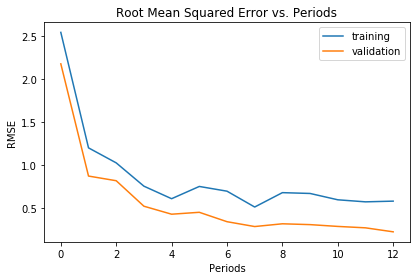

In [15]:
# model missing data
missing_data_set = pd.DataFrame({
    '1stFlrSF':normalize(train_data['1stFlrSF']),
    'GrLivArea':normalize(train_data['GrLivArea']),
    'OverallQual':normalize(train_data['OverallQual']),
    'FullBath':normalize(train_data['FullBath']),
    'TotalBsmtSF':normalize(train_data['TotalBsmtSF']),
    'BsmtQual1':train_data['BsmtQual1'],
    'BsmtQual2':train_data['BsmtQual2'],
    'BsmtQual3':train_data['BsmtQual3'],
    'BsmtQual4':train_data['BsmtQual4'],
    'SalePrice':np.log(train_data['SalePrice']),
})

# missing_data_set.isnull().sum()

estimator = train(
    learning_rate = 0.01,
    batch_size = 10,
    steps = 100,
    periods = 13,
    train_example = missing_data_set,
    mod_dir='./tensorboard/missing2/train1'
)

In [24]:
# Final prediction
def test_input(test_example):
    test_input_fn = tf.estimator.inputs.pandas_input_fn(
          x=test_example,
          num_epochs=1, # only to predict
          shuffle=False,
    )
    return test_input_fn

tmp = test_data['TotalBsmtSF'].copy().dropna()
tmp = test_data['TotalBsmtSF'].sum() / len(test_data['TotalBsmtSF'])
test_data['TotalBsmtSF'] = test_data['TotalBsmtSF'].fillna(tmp)
# print(test_simple_example['TotalBsmtSF'].isnull().sum())

tmp = test_data['GrLivArea'].copy().dropna()
tmp = test_data['GrLivArea'].sum() / len(test_data['GrLivArea'])
test_data['GrLivArea'] = test_data['GrLivArea'].fillna(tmp)

test = pd.DataFrame({
    '1stFlrSF':normalize(test_data['1stFlrSF']),
    'GrLivArea':normalize(test_data['GrLivArea']),
    'OverallQual':normalize(test_data['OverallQual']),
    'FullBath':normalize(test_data['FullBath']),
    'TotalBsmtSF':normalize(test_data['TotalBsmtSF']),
    'BsmtQual1':test_data['BsmtQual1'],
    'BsmtQual2':test_data['BsmtQual2'],
    'BsmtQual3':test_data['BsmtQual3'],
    'BsmtQual4':test_data['BsmtQual4'],
})

# display.display(test_data_copy.info())
final_input = test_input(test)

predictions = list(estimator.predict(input_fn=final_input))
predicted_classes = [math.exp(float(prediction['predictions'][0])) for prediction in predictions]

evaluation = test_data_copy['Id'].copy().to_frame()
print(len(predicted_classes), len(evaluation))
evaluation["SalePrice"] = predicted_classes
evaluation.to_csv("evaluation_submission.csv", index=False)
# evaluation["actual"] = train_data.SalePrice
display.display(evaluation.describe())
display.display(evaluation)


1459 1459


,Id,SalePrice
count,1459.000000,1.459000e+03
mean,2190.000000,1.895470e+05
std,421.321334,1.238975e+05
min,1461.000000,1.579302e+04
25%,1825.500000,1.290496e+05
50%,2190.000000,1.626580e+05
75%,2554.500000,2.095081e+05
max,2919.000000,2.893116e+06


,Id,SalePrice
0,1461,119397.345745
1,1462,181479.879572
2,1463,154121.504281
3,1464,158570.290483
4,1465,203646.733787
5,1466,171026.517800
6,1467,158726.279527
7,1468,153579.948452
8,1469,181517.440235
9,1470,109827.746038


In [ ]:
predictions = list(estimator.predict(input_fn=final_input))